# Read in the data

In [1]:
import pandas as pd
import numpy
import re
import matplotlib.pyplot as plt
%matplotlib inline

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d


# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

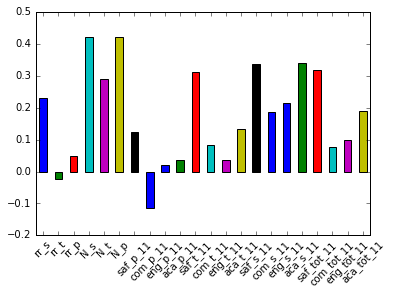

In [11]:
correlations[survey_fields].plot.bar(rot=45)

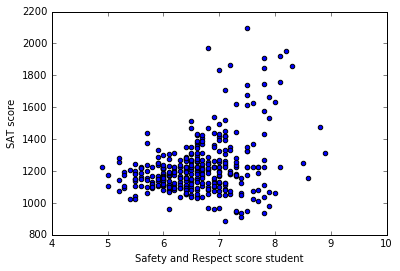

In [12]:
plt.scatter(combined['saf_s_11'], combined['sat_score'])
plt.xlabel('Safety and Respect score student')
plt.ylabel('SAT score')
plt.show()

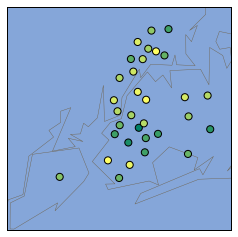

In [13]:
import numpy
districts = combined.groupby('school_dist').agg(numpy.mean)
districts.reset_index(inplace=True)
districts.head()

from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = districts.lon.tolist()
latitudes = districts.lat.tolist()

m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=districts['saf_s_11'], cmap='summer')
plt.show()

As we can see schools with highest safety students scores located in South Brooklyn, West Queens and East Bronx. Although Manhattan hasn't best scores howether mean safety scores concentrated in this borrough.

# Plotting races correlations

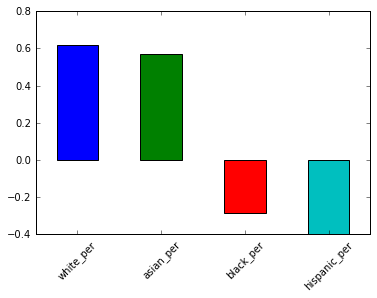

In [14]:
races = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
correlations[races].plot.bar(rot=45)

There are average SAT direct correlations with white and asian students, and weak reverse correlation with black and hispanic students.

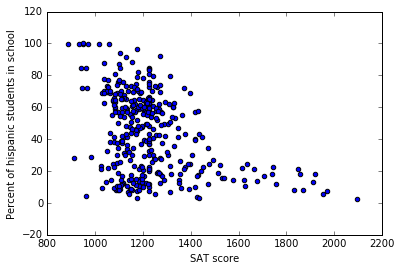

In [15]:
plt.scatter(x=combined['sat_score'],y=combined['hispanic_per'])
plt.xlabel('SAT score')
plt.ylabel('Percent of hispanic students in school')
plt.show()

We can see linear relation which show that the less hispanic students the more SAT score. And schools with more then 1500 SAT score has less 20 percents of hispanic student.

In [16]:
combined.loc[combined['hispanic_per'] > 95,'school_name']

44                         Manhattan Bridges High School
82      Washington Heights Expeditionary Learning School
89     Gregorio Luperon High School for Science and M...
125                  Academy for Language and Technology
141                International School for Liberal Arts
176     Pan American International High School at Monroe
253                            Multicultural High School
286               Pan American International High School
Name: school_name, dtype: object

In [17]:
combined.loc[(combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800), 'school_name']

37                                Stuyvesant High School
151                         Bronx High School of Science
187                       Brooklyn Technical High School
327    Queens High School for the Sciences at York Co...
356                  Staten Island Technical High School
Name: school_name, dtype: object

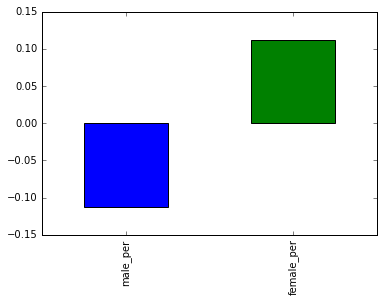

In [18]:
correlations[['male_per','female_per']].plot.bar()

Gender has weak correlation with SAT score but the interesting observation is that female has direct correlation and male has reverse, which means if school has more girls the SAT score would be probably higher.

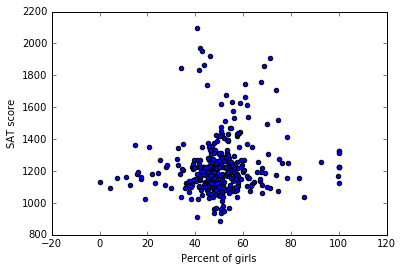

In [19]:
plt.scatter(combined['female_per'], combined['sat_score'])
plt.xlabel('Percent of girls')
plt.ylabel('SAT score')
plt.show()

We got  big cluster in range 40-60 percent of girls which has SAT scrore in range 1000-1400. In range 40-80 of female percent there are most succesful SAT result.

In [20]:
combined.loc[(combined['sat_score'] > 1700) & (combined['female_per'] > 60), 'school_name']

5                         Bard High School Early College
26                         Eleanor Roosevelt High School
60                                    Beacon High School
61     Fiorello H. LaGuardia High School of Music & A...
302                          Townsend Harris High School
Name: school_name, dtype: object

In [21]:
combined['ap_per'] = (combined['AP Test Takers '] / combined['total_enrollment']) * 100
# calculate the percentage of students in each school that took an AP exam

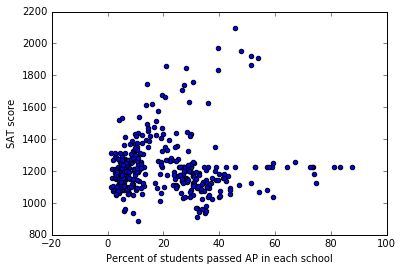

In [22]:
plt.scatter(combined['ap_per'], combined['sat_score'])
plt.xlabel('Percent of students passed AP in each school')
plt.ylabel('SAT score')
plt.show()

Gotten  two clusters. One of them show schools where students doesn't passed AP or percent less than 15 although some of them passed SAT more than 1000 and until 1400 score. Other has bigger scatter and located between 20 and 40 percent of students passed AP in school. Also there are some amount of outliers. As we see there is no relation between  'Percent of students passed AP in each school' and 'SAT score in school'.

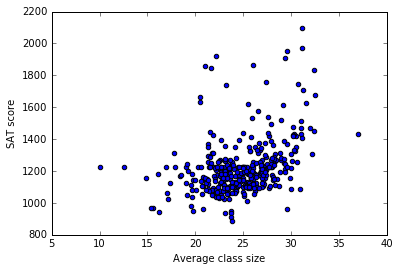

In [23]:
plt.scatter( combined['AVERAGE CLASS SIZE'],combined['sat_score'])
plt.xlabel('Average class size')
plt.ylabel('SAT score')
plt.show()

As we can see in main cluster, class size have slighty increasing relation with SAT score.

In [24]:
combined.loc[(combined['sat_score'] > combined['sat_score'].mean()) , 'school_dist'].value_counts()[:10]

02    25
31     9
25     6
28     6
24     6
30     6
10     6
21     5
26     4
03     4
Name: school_dist, dtype: int64

Here we've got most success districts, where are more schools in whose students gotten SAT more then average score.

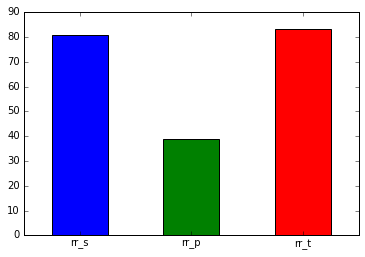

In [33]:
combined[['rr_s','rr_p','rr_t']].mean().plot.bar(rot=0)

Differences berween studen, parents, and teachers response rate

In [ ]:
combined[['rr_s','rr_p','rr_t']].mean().plot.bar(rot=0)

In [ ]:
cut_score = pd.cut(combined['sat_score'],5).value_counts().sort_index(ascending=False).index
school_rank = {}
for i in range(len(cut_score)):
    school_rank[cut_score[i]] = i+1
print(school_rank)
combined['sat_school_rank'] = combined['sat_score'].map(school_rank)
combined['sat_school_rank'].head()
# add new column SAT score school rank